**Import Bibliotheken**

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from IPython.display import display, HTML

**Datenansicht**

In [26]:
df = pd.read_csv("Dataset.csv")
df = df[df["Article Citation Count"].notna()]   #Aussortieren Artikel ohne Zitationen
df = df[df["Publication Year"] != "Publication Year"]   # 4 Datensätze waren die Columns (vermutlich wegen merge)
df["Publication Year"] = df["Publication Year"].astype(int)
df["Article Citation Count"] = df["Article Citation Count"].astype(int)
df

,Document Title,Authors,Author Affiliations,Publication Title,Date Added To Xplore,Publication Year,Volume,Issue,Start Page,End Page,...,Mesh_Terms,Article Citation Count,Patent Citation Count,Reference Count,License,Online Date,Issue Date,Meeting Date,Publisher,Document Identifier
0,The role of inspection in software quality ass...,D. L. Parnas; M. Lawford,"Software Quality Research Laboratory, Universi...",IEEE Transactions on Software Engineering,26 Aug 2003,2003,29,8,674,676,...,NaN,58,NaN,NaN,IEEE,26 Aug 2003,NaN,NaN,IEEE,IEEE Journals
1,Modular verification of software components in C,S. Chaki; E. M. Clarke; A. Groce; S. Jha; H. V...,"School of Computer Science, Carnegie Mellon Un...",IEEE Transactions on Software Engineering,9 Aug 2004,2004,30,6,388,402,...,NaN,146,3,60,IEEE,9 Aug 2004,NaN,NaN,IEEE,IEEE Journals
2,"Response To: Comments On ""property-based Softw...",L. C. Briand; S. Morasca; V. R. Basili,Fraunhofer Institute of Experimental Software ...,IEEE Transactions on Software Engineering,6 Aug 2002,1997,23,3,196,197,...,NaN,14,NaN,1,IEEE,6 Aug 2002,NaN,NaN,IEEE,IEEE Journals
3,Toward a mathematical foundation of software e...,M. Broy,"Institut f ür Informatik, Technische Universit...",IEEE Transactions on Software Engineering,7 Aug 2002,2001,27,1,42,57,...,NaN,13,NaN,31,IEEE,7 Aug 2002,NaN,NaN,IEEE,IEEE Journals
4,Evaluation of several nonparametric bootstrap ...,Skylar Lei; M. R. Smith,"Dynamics Canada, Calgary, AB, Canada; Departme...",IEEE Transactions on Software Engineering,17 Nov 2003,2003,29,11,996,1004,...,NaN,35,NaN,24,IEEE,17 Nov 2003,NaN,NaN,IEEE,IEEE Journals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4120,Automatic input rectification,F. Long; V. Ganesh; M. Carbin; S. Sidiroglou; ...,"CSAIL, MIT, USA; CSAIL, MIT, USA; CSAIL, MIT, ...",2012 34th International Conference on Software...,28 Jun 2012,2012,NaN,NaN,80,90,...,NaN,25,1,38,IEEE,28 Jun 2012,NaN,NaN,IEEE,IEEE Conferences
4121,Debugger Canvas: Industrial experience with th...,R. DeLine; A. Bragdon; K. Rowan; J. Jacobsen; ...,"Microsoft Research, Visual Studio Ultimate Mic...",2012 34th International Conference on Software...,28 Jun 2012,2012,NaN,NaN,1064,1073,...,NaN,20,1,19,IEEE,28 Jun 2012,NaN,NaN,IEEE,IEEE Conferences
4122,Static detection of resource contention proble...,Y. Zheng; X. Zhang,"Department of Computer Science, Purdue Univers...",2012 34th International Conference on Software...,28 Jun 2012,2012,NaN,NaN,584,594,...,NaN,15,1,37,IEEE,28 Jun 2012,NaN,NaN,IEEE,IEEE Conferences
4123,Inferring class level specifications for distr...,S. Kumar; S. -C. Khoo; A. Roychoudhury; D. Lo,"National University of Singapore, Singapore; N...",2012 34th International Conference on Software...,28 Jun 2012,2012,NaN,NaN,914,924,...,NaN,12,NaN,39,IEEE,28 Jun 2012,NaN,NaN,IEEE,IEEE Conferences


**Funktionen**

In [27]:
def GetDocumentsBetween(data,year1,year2):              #liefert Dataframe zwischen zwei Jahren zurück
    data = data[data["Publication Year"] < year2 ]
    data = data[data["Publication Year"] >= year1 ]
    return data
def get_keywords(dataframe,column): 
    dataframe["Article Citation Count"] = pd.to_numeric(dataframe["Article Citation Count"], errors='coerce').fillna(0)                    #Liefert Liste mit Keywords und Zitationsanzahl
    texts = dataframe[column].fillna("")  
    vectorizer = CountVectorizer(stop_words="english", max_features=1000)
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    keyword_citations = pd.DataFrame(X.toarray(), columns=keywords)
    keyword_citations["Article Citation Count"] = dataframe["Article Citation Count"]
    keyword_citations_sum = (
        keyword_citations.drop(columns="Article Citation Count").mul(keyword_citations["Article Citation Count"], axis=0).sum().sort_values(ascending=False)
)
    return keyword_citations_sum
def Group_by_Topics(df):
    df["Article Citation Count"] = pd.to_numeric(df["Article Citation Count"], errors='coerce').fillna(0)

    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(df["Document Title"].dropna())

    # Perform topic modeling with LDA
    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(X)

    # Extract the top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
     top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
     topics[f"Topic {topic_idx+1}"] = top_words

# Assign each document to a topic
    dominant_topics = lda.transform(X).argmax(axis=1)
    data_with_topics = df.copy()
    data_with_topics["Dominant Topic"] = dominant_topics
    data_with_topics["Topic Keywords"] = [
        ", ".join(topics[f"Topic {i+1}"]) for i in dominant_topics
    ]

    # Aggregate citation counts by topics
    topic_citations = data_with_topics.groupby("Topic Keywords")["Article Citation Count"].sum().sort_values(ascending=False).head(5)
    return topic_citations


**Top 10 Publikatioen**

In [28]:
top_10_article = df.sort_values(by="Article Citation Count",ascending=False).head(10)
top_10_2014_2024 = GetDocumentsBetween(df,2014,2025).sort_values(by="Article Citation Count",ascending=False).head(10)
top_10_2004_2014 = GetDocumentsBetween(df,2004,2014).sort_values(by="Article Citation Count",ascending=False).head(10)
top_10_1994_2014 = GetDocumentsBetween(df,1994,2004).sort_values(by="Article Citation Count",ascending=False).head(10)

**Top 10 Artikel Gesamt und Dekaden**

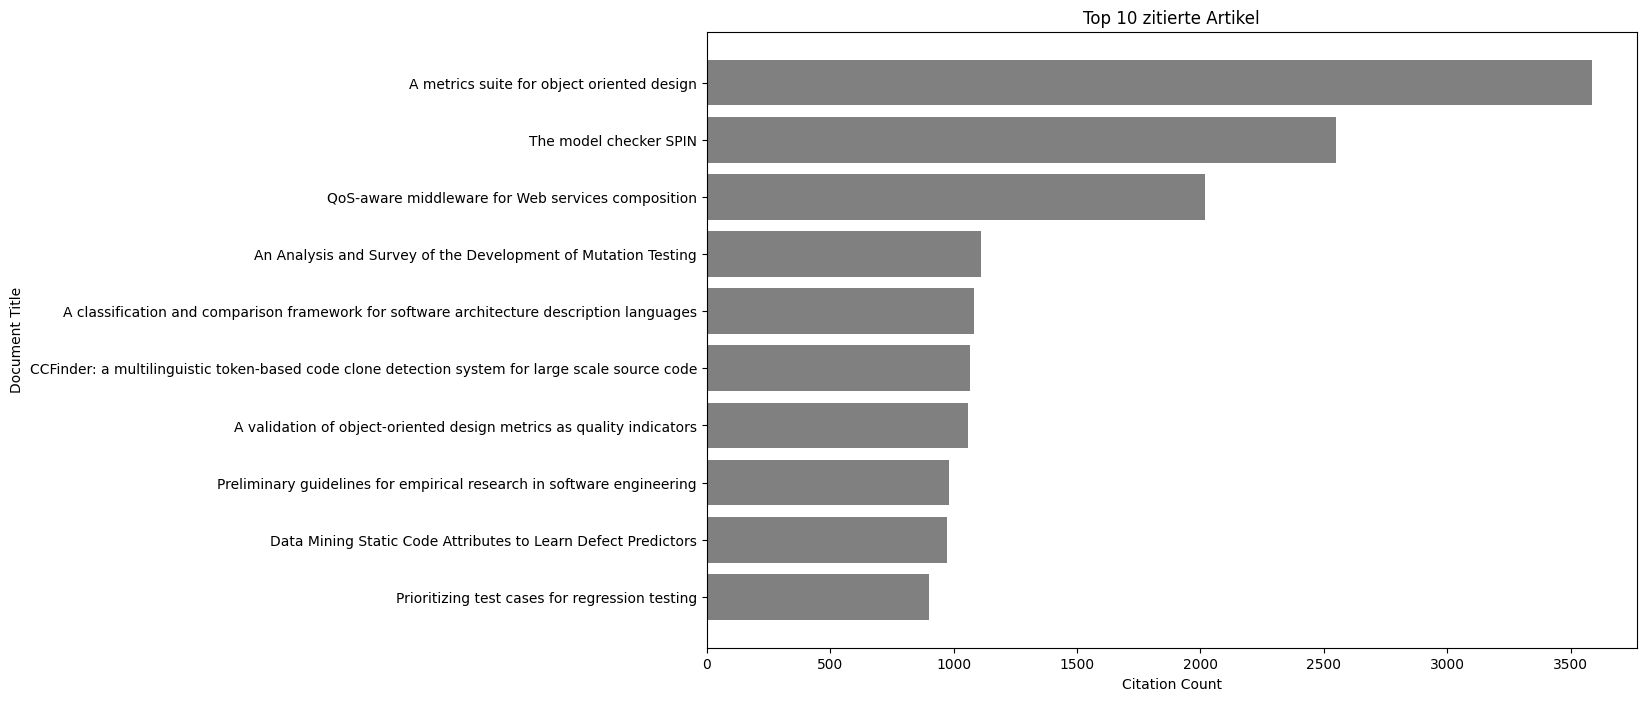

In [29]:
plt.figure(figsize=(12, 8))
plt.barh(top_10_article["Document Title"], top_10_article["Article Citation Count"], color='grey')
plt.xlabel("Citation Count")
plt.ylabel("Document Title")
plt.title("Top 10 zitierte Artikel")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

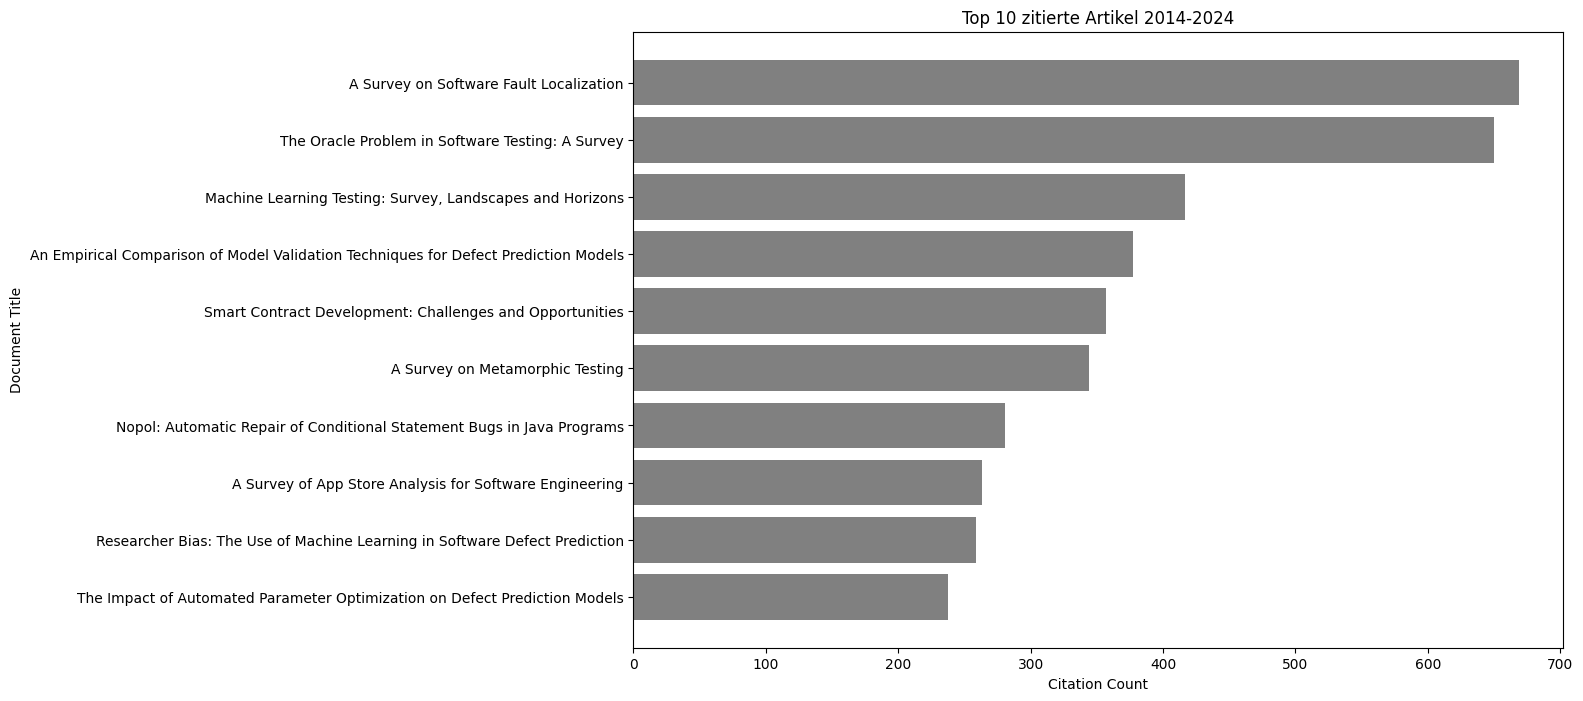

In [30]:
plt.figure(figsize=(12, 8))
plt.barh(top_10_2014_2024["Document Title"], top_10_2014_2024["Article Citation Count"], color='grey')
plt.xlabel("Citation Count")
plt.ylabel("Document Title")
plt.title("Top 10 zitierte Artikel 2014-2024")
plt.gca().invert_yaxis()  
plt.show()

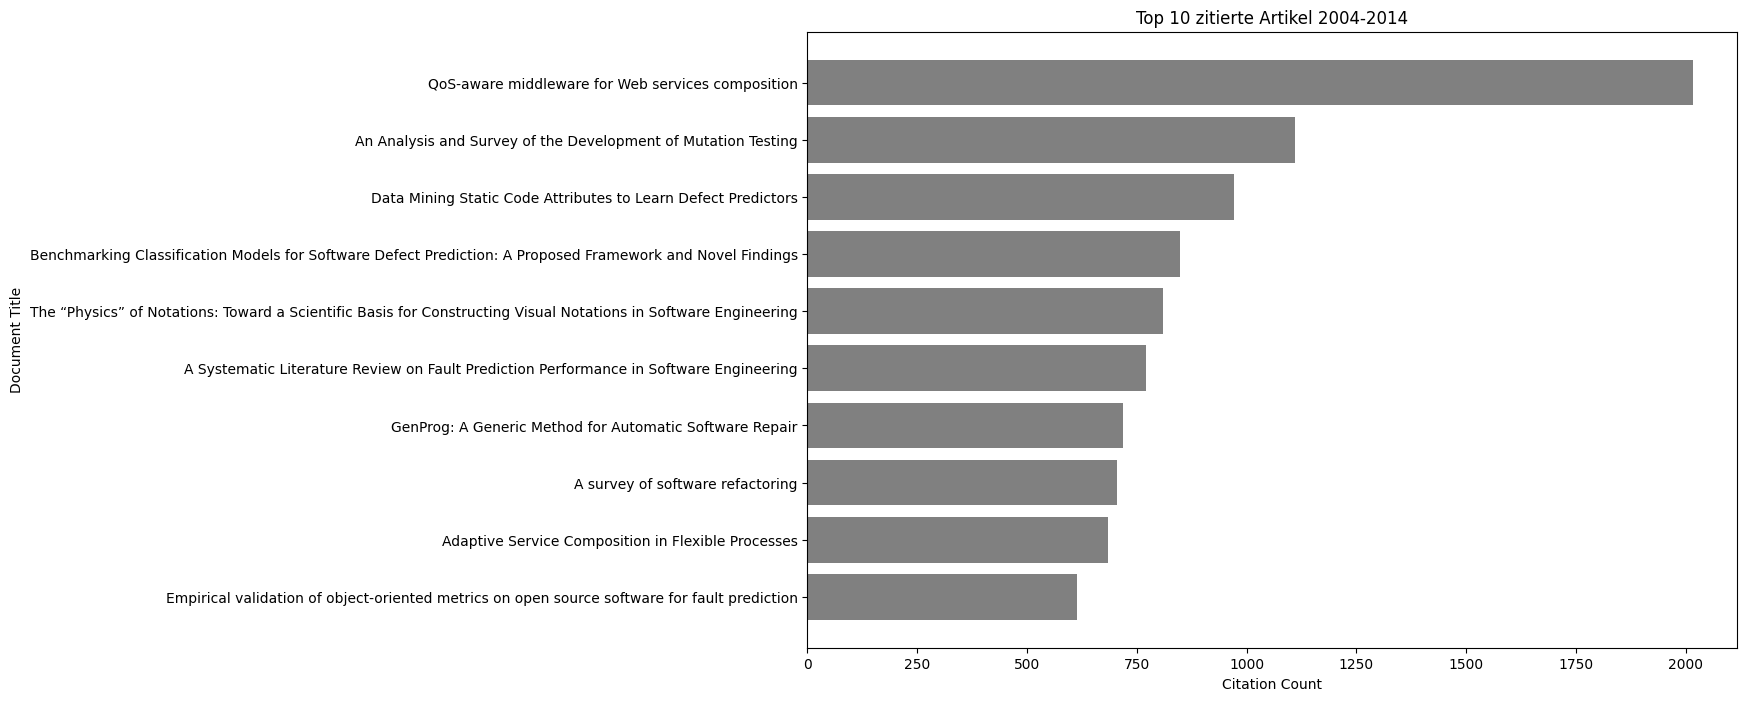

In [31]:
plt.figure(figsize=(12, 8))
plt.barh(top_10_2004_2014["Document Title"], top_10_2004_2014["Article Citation Count"], color='grey')
plt.xlabel("Citation Count")
plt.ylabel("Document Title")
plt.title("Top 10 zitierte Artikel 2004-2014")
plt.gca().invert_yaxis()  
plt.show()

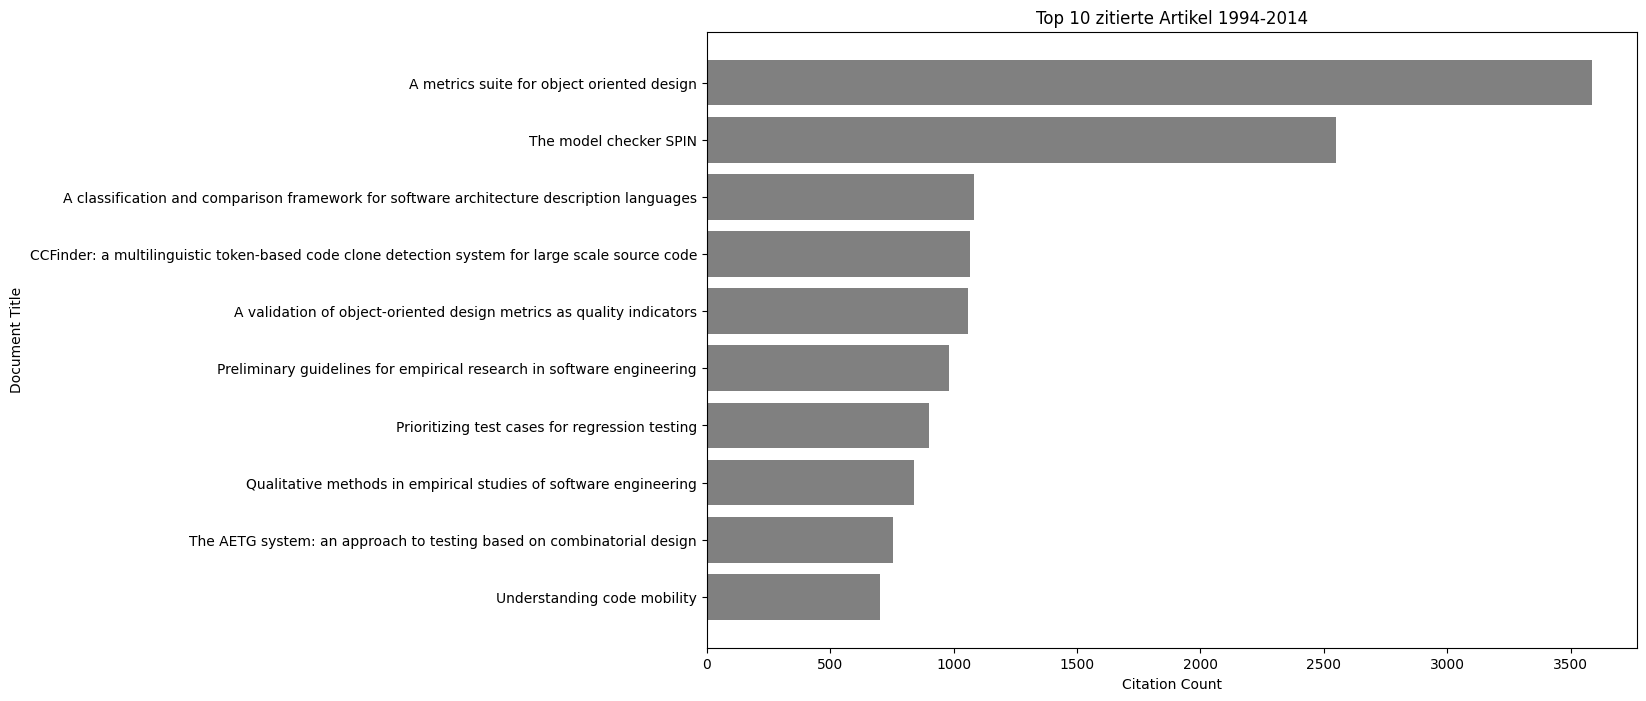

In [32]:
plt.figure(figsize=(12, 8))
plt.barh(top_10_1994_2014["Document Title"], top_10_1994_2014["Article Citation Count"], color='grey')
plt.xlabel("Citation Count")
plt.ylabel("Document Title")
plt.title("Top 10 zitierte Artikel 1994-2014")
plt.gca().invert_yaxis()  
plt.show()

In [33]:
top_10_article_relation_year = df
df_year = 2024 - top_10_article_relation_year["Publication Year"]
df_year.replace(0,1,inplace=True)
top_10_article_relation_year["Average Citation Year"] = top_10_article_relation_year["Article Citation Count"] / df_year
top_10_article_relation_year = top_10_article_relation_year.sort_values(by="Average Citation Year",ascending=False).head(10)
top_10_article_relation_year

,Document Title,Authors,Author Affiliations,Publication Title,Date Added To Xplore,Publication Year,Volume,Issue,Start Page,End Page,...,Article Citation Count,Patent Citation Count,Reference Count,License,Online Date,Issue Date,Meeting Date,Publisher,Document Identifier,Average Citation Year
2644,"Machine Learning Testing: Survey, Landscapes a...",J. M. Zhang; M. Harman; L. Ma; Y. Liu,"CREST, University College London, London, U.K;...",IEEE Transactions on Software Engineering,10 Jan 2022,2022,48,1,1,36,...,417,NaN,292,IEEE,17 Feb 2020,NaN,NaN,IEEE,IEEE Journals,208.500000
240,A metrics suite for object oriented design,S. R. Chidamber; C. F. Kemerer,"Massachusetts Institute of Technology, Cambrid...",IEEE Transactions on Software Engineering,6 Aug 2002,1994,20,6,476,493,...,3588,12,50,IEEE,6 Aug 2002,NaN,NaN,IEEE,IEEE Journals,119.600000
2075,Smart Contract Development: Challenges and Opp...,W. Zou; D. Lo; P. S. Kochhar; X. -B. D. Le; X....,State Key Laboratory for Novel Software Techno...,IEEE Transactions on Software Engineering,14 Oct 2021,2021,47,10,2084,2106,...,357,NaN,160,IEEE,24 Sep 2019,NaN,NaN,IEEE,IEEE Journals,119.000000
3143,Deep Learning Based Vulnerability Detection: A...,S. Chakraborty; R. Krishna; Y. Ding; B. Ray,"Columbia University, New York, NY, USA; Columb...",IEEE Transactions on Software Engineering,16 Sep 2022,2022,48,9,3280,3296,...,210,NaN,76,IEEE,8 Jun 2021,NaN,NaN,IEEE,IEEE Journals,105.000000
685,QoS-aware middleware for Web services composition,Liangzhao Zeng; B. Benatallah; A. H. H. Ngu; M...,"IBM Thomas J. Watson Research Center, Yorktown...",IEEE Transactions on Software Engineering,4 May 2004,2004,30,5,311,327,...,2017,22,43,IEEE,4 May 2004,NaN,NaN,IEEE,IEEE Journals,100.850000
293,The model checker SPIN,G. J. Holzmann,"Bell Laboratories, Computing Sciences Research...",IEEE Transactions on Software Engineering,6 Aug 2002,1997,23,5,279,295,...,2549,26,82,IEEE,6 Aug 2002,NaN,NaN,IEEE,IEEE Journals,94.407407
1400,An Analysis and Survey of the Development of M...,Y. Jia; M. Harman,"Centre for Research on Evolution, Search and T...",IEEE Transactions on Software Engineering,29 Sep 2011,2011,37,5,649,678,...,1110,3,264,IEEE,17 Jun 2010,NaN,NaN,IEEE,IEEE Journals,85.384615
1886,A Survey on Software Fault Localization,W. E. Wong; R. Gao; Y. Li; R. Abreu; F. Wotawa,"State Key Laboratory of Software Engineering, ...",IEEE Transactions on Software Engineering,11 Aug 2016,2016,42,8,707,740,...,669,NaN,427,IEEE,25 Jan 2016,NaN,NaN,IEEE,IEEE Journals,83.625000
2181,The Oracle Problem in Software Testing: A Survey,E. T. Barr; M. Harman; P. McMinn; M. Shahbaz; ...,"Department of Computer Science, University Col...",IEEE Transactions on Software Engineering,12 May 2015,2015,41,5,507,525,...,650,NaN,86,CCBY,20 Nov 2014,NaN,NaN,IEEE,IEEE Journals,72.222222
1965,"The Art, Science, and Engineering of Fuzzing: ...",V. J. M. Manès; H. Han; C. Han; S. K. Cha; M. ...,"KAIST Cyber Security Research Center, Daejeon,...",IEEE Transactions on Software Engineering,11 Nov 2021,2021,47,11,2312,2331,...,193,NaN,250,IEEE,11 Oct 2019,NaN,NaN,IEEE,IEEE Journals,64.333333


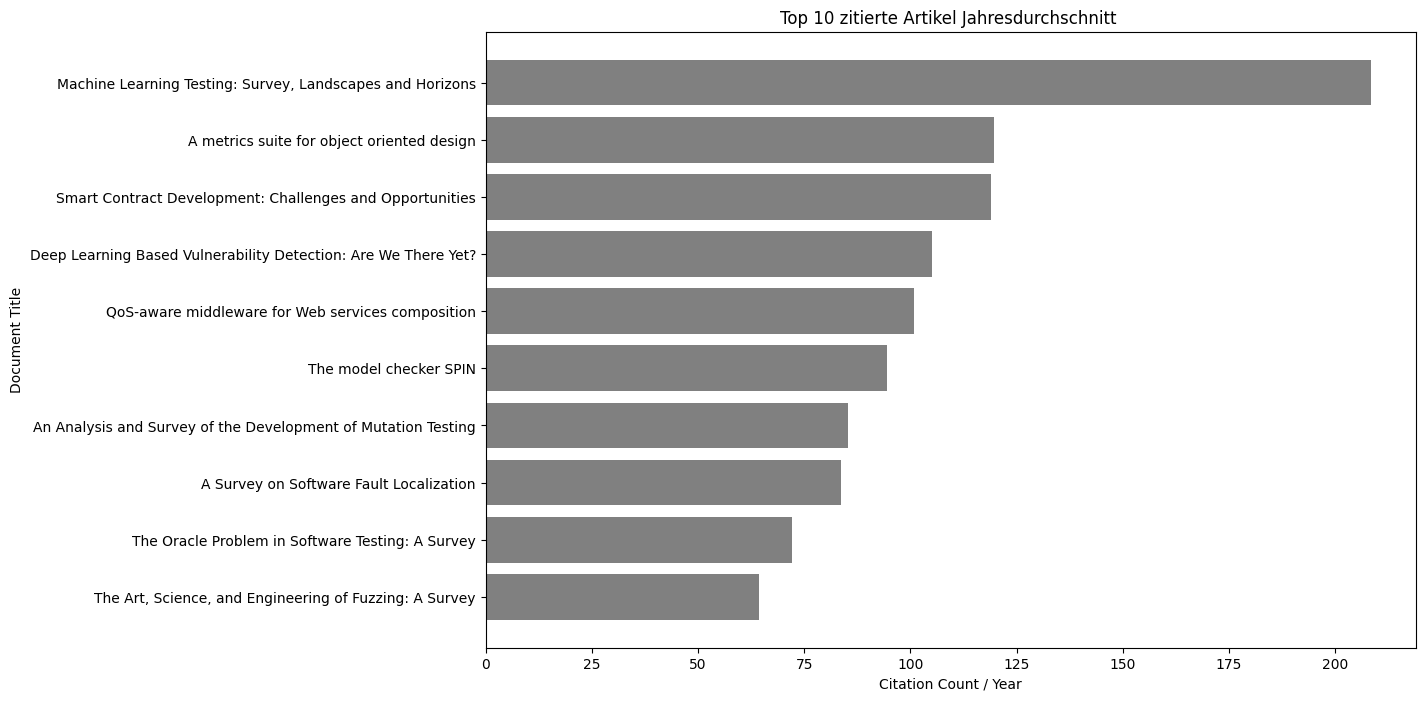

In [34]:
plt.figure(figsize=(12, 8))
plt.barh(top_10_article_relation_year["Document Title"], top_10_article_relation_year["Average Citation Year"], color='grey')
plt.xlabel("Citation Count / Year")
plt.ylabel("Document Title")
plt.title("Top 10 zitierte Artikel Jahresdurchschnitt ")
plt.gca().invert_yaxis()  
plt.show()

**Überprüfung Korrelation zwischen Zitaten und Referenzen**

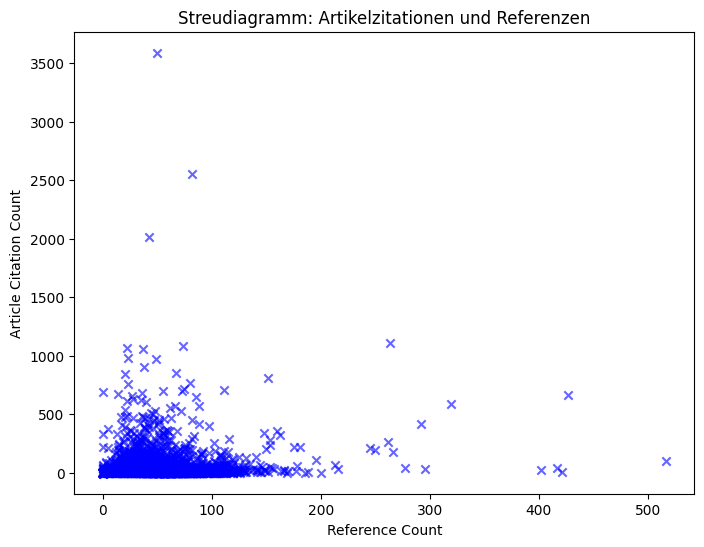

0.04542062762130813
-0.07931784625685913


In [35]:
df["Article Citation Count"] = pd.to_numeric(df["Article Citation Count"], errors='coerce').fillna(0)
df["Reference Count"] = pd.to_numeric(df["Reference Count"], errors='coerce').fillna(0)

pearson_corr = df["Article Citation Count"].corr(df["Reference Count"])
spearman_corr = df["Article Citation Count"].corr(df["Reference Count"], method='spearman')
plt.figure(figsize=(8, 6))
plt.scatter(df["Reference Count"], df["Article Citation Count"],marker='x', alpha=0.6,c='blue')
plt.xlabel("Reference Count")
plt.ylabel("Article Citation Count")
plt.title("Streudiagramm: Artikelzitationen und Referenzen")
plt.show()

print(pearson_corr)
print(spearman_corr)

**Überschneidungen bei den Top5 zitierten Topics/Keywords**

In [36]:
df_2014_2024 = Group_by_Topics(GetDocumentsBetween(df,2014,2025))
df_2014_2024 = df_2014_2024.reset_index()
df_2004_2014=Group_by_Topics(GetDocumentsBetween(df,2004,2014))
df_2004_2014 = df_2004_2014.reset_index()
df_1994_2004 = Group_by_Topics(GetDocumentsBetween(df,1994,2004))
df_1994_2004 = df_1994_2004.reset_index()

In [37]:
display(HTML(df_2014_2024.to_html()))

,Topic Keywords,Article Citation Count
0,"learning, software, study, prediction, defect, empirical, based, deep, localization, detection",7033
1,"testing, based, systems, model, test, analysis, software, learning, performance, mobile",4807
2,"code, source, learning, review, open, systematic, software, models, literature, technical",3650
3,"software, engineering, study, case, based, test, systems, improving, requirements, search",3078
4,"software, using, stack, code, patterns, detecting, based, mining, overflow, aware",3054


In [38]:
display(HTML(df_2004_2014.to_html()))

,Topic Keywords,Article Citation Count
0,"software, engineering, language, maintenance, process, mining, special, systematic, testing, support",10940
1,"software, code, source, using, models, defect, mining, based, design, open",8286
2,"software, analysis, development, requirements, estimation, specifications, systems, effort, studies, method",7357
3,"software, development, study, model, empirical, programming, case, industrial, object, oriented",6320
4,"based, testing, software, systems, test, analysis, search, applications, component, approach",6178


In [39]:
display(HTML(df_1994_2004.to_html()))

,Topic Keywords,Article Citation Count
0,"oriented, object, software, design, metrics, analysis, based, testing, test, framework",17596
1,"software, models, engineering, estimation, using, cost, methods, analysis, model, reliability",9458
2,"analysis, program, software, automatic, using, language, code, framework, engineering, data",6763
3,"software, formal, verification, process, control, language, based, development, analysis, model",5561
4,"systems, time, real, distributed, software, design, based, performance, testing, analysis",5416


In [40]:
words_df1 = set(word.strip() for keywords in df_1994_2004["Topic Keywords"] for word in keywords.split(","))
words_df2 = set(word.strip() for keywords in df_2004_2014["Topic Keywords"] for word in keywords.split(","))
words_df3 = set(word.strip() for keywords in df_2014_2024["Topic Keywords"] for word in keywords.split(","))

common_words_all = words_df1.intersection(words_df2).intersection(words_df3) # Überschneidungen
unique_to_df1 = words_df1.difference(words_df2.union(words_df3)) # nur in words1
unique_to_df2 = words_df2.difference(words_df1.union(words_df3)) # nur in words2
unique_to_df3 = words_df3.difference(words_df1.union(words_df2)) # nur in words3

In [41]:
common_words_all


{'analysis',
 'based',
 'code',
 'engineering',
 'model',
 'models',
 'software',
 'systems',
 'test',
 'testing',
 'using'}

In [42]:
unique_to_df1

{'automatic',
 'control',
 'cost',
 'data',
 'distributed',
 'formal',
 'framework',
 'methods',
 'metrics',
 'program',
 'real',
 'reliability',
 'time',
 'verification'}

In [43]:
unique_to_df2

{'applications',
 'approach',
 'component',
 'effort',
 'industrial',
 'maintenance',
 'method',
 'programming',
 'special',
 'specifications',
 'studies',
 'support'}

In [44]:
unique_to_df3

{'aware',
 'deep',
 'detecting',
 'detection',
 'improving',
 'learning',
 'literature',
 'localization',
 'mobile',
 'overflow',
 'patterns',
 'prediction',
 'review',
 'stack',
 'technical'}